In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"#"2"

In [2]:
# import estimator class
from estimators.rnnEstimator import RnnEstimator

#import rewarder class
from rewarders.thresholdRewarder import ThresholdRewarder

from matplotlib import pyplot
from utils.sequences_treatment import *
from utils.agent_treatment import *

# import functions from Keras for the RNN
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN#, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packag

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 48 samples, validate on 12 samples
Epoch 1/2
 - 8s - loss: 0.1767 - val_loss: 0.1053
Epoch 2/2
 - 3s - loss: 0.1054 - val_loss: 0.0917


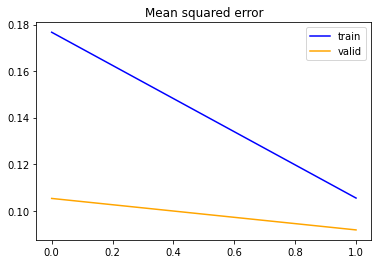

In [3]:
# construct and train a Sequential RNN model with keras
numberSamples=60
T_train=20
generatorType='random01'

# generate sequences for training
(obj_train,meas_train)=generateSequence(T_train,numberSamples=numberSamples,generatorType=generatorType)
sigma=randomSigma(T_train,numberSamples=numberSamples,p0=0.2)
meas_train_corrupted=corruptSequence_outOfRange(meas_train,sigma)

n_dim_meas=np.shape(meas_train_corrupted)[2]
n_dim_obj=np.shape(obj_train)[2]

model=Sequential()
model.add(LSTM(20,input_shape=(None,n_dim_meas),return_sequences=True))
model.add(LSTM(20,return_sequences=True))
model.add(Dense(n_dim_obj,activation=None))

model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()

# train the RNN
history=model.fit(x=meas_train_corrupted,y=obj_train,batch_size=1,epochs=2,validation_split=0.2,verbose=2)

# plot loss
plotRNNresults(history)

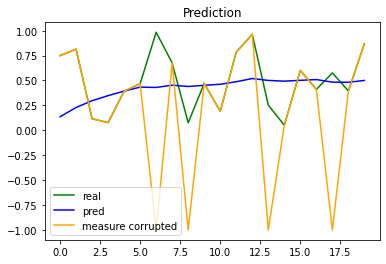

In [4]:
# plot estimation
indToPlot=40
obj_train_pred=model.predict(meas_train_corrupted[indToPlot:(indToPlot+1),:,:])

pyplot.title('Prediction')
pyplot.plot(obj_train[indToPlot,:,0], color='green', label='real')
pyplot.plot(obj_train_pred[0,:,0], color='blue', label='pred')
pyplot.plot(meas_train_corrupted[indToPlot,:,0], color='orange', label='measure corrupted')
pyplot.legend()
pyplot.show()

In [5]:
# construct estimator
estimator=RnnEstimator(model,generatorType)
estimator.summarize()

# contruct rewarder
rewarder=ThresholdRewarder(threshold=2, cost=5000, windowSize=4)
rewarder.summarize()

No function summarize() implemented in default Estimator class.
window size: 4
threshold: 2
cost: 5000
number of measures in the window: 0


In [6]:
# generate sequences for training the agent
T=T_train

(objectives,measurements)=estimator.generateSequence(T,numberSamples=numberSamples)

print('shape objectives:',np.shape(objectives))
print('shape measurements:',np.shape(measurements))

shape objectives: (60, 20, 1)
shape measurements: (60, 20, 1)


In [7]:
# construct agent
agent=constructAgent(estimator,rewarder,objectives,measurements)
print('Agent constructed')

Environment parameters
  REWARDER= <rewarders.thresholdRewarder.ThresholdRewarder object at 0xb37d5f550>
  inputDimensions= [(5,), (5, 1)]
Sequences parameters
  outOfRangeValue= -1
  numerSamples= 60
  n_dim_obj= 1
  n_dim_meas= 1
Agent constructed


In [8]:
# Train the RL agent
agent.run(n_epochs=1, epoch_length=numberSamples*T)
print('Agent Trained')

/Users/antoine/Desktop/optiMeasRL-main/optimalIntermittency.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(self._last_ponctual_observation)


Average (on the epoch) training loss: 1118.043212890625
Episode average V value: -0.11759836971759796
Average (on the epoch) training loss: 777.91259765625
Episode average V value: 0.045244669914245604
Average (on the epoch) training loss: 648.918701171875
Episode average V value: 0.2922886908054352
Average (on the epoch) training loss: 549.7392578125
Episode average V value: -0.3186084717512131
Average (on the epoch) training loss: 475.9159240722656
Episode average V value: -0.23286117669194936
Average (on the epoch) training loss: 419.17254638671875
Episode average V value: -1.055961886793375
Average (on the epoch) training loss: 372.69781494140625
Episode average V value: -0.32869402356445787
Average (on the epoch) training loss: 338.0064392089844
Episode average V value: -1.0147069655358791
Average (on the epoch) training loss: 308.11749267578125
Episode average V value: 0.3345816135406494
Average (on the epoch) training loss: 278.2925109863281
Episode average V value: 2.6523756694

In [9]:
# generate test data
numberSamples_test=10
T_test=20
(objectives_test,measurements_test)=estimator.generateSequence(T_test,numberSamples=numberSamples_test)

# Results of the inference on test data
(testResults_sigmas,testResults_rewards,testResults_estimates)=agentInference(agent,objectives_test,measurements_test)

Inference start
Average (on the epoch) training loss: 41.73851013183594
Episode average V value: 13.201913833618164
Average (on the epoch) training loss: 65.5539779663086
Episode average V value: 10.221692085266113
Average (on the epoch) training loss: 57.40332794189453
Episode average V value: 4.90572452545166
Average (on the epoch) training loss: 48.4311637878418
Episode average V value: 10.251456260681152
Average (on the epoch) training loss: 50.190120697021484
Episode average V value: 13.118266105651855
Average (on the epoch) training loss: 43.253597259521484
Episode average V value: 5.152822494506836
Average (on the epoch) training loss: 40.78902816772461
Episode average V value: 2.8560140132904053
Average (on the epoch) training loss: 37.731956481933594
Episode average V value: 4.754577159881592
Average (on the epoch) training loss: 41.67586135864258
Episode average V value: -5.218034267425537
Average (on the epoch) training loss: 40.47417068481445
Episode average V value: 1.6904

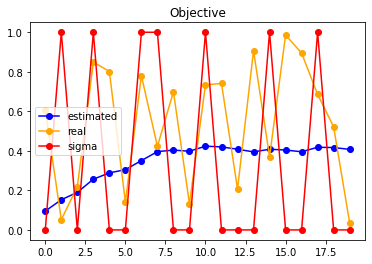

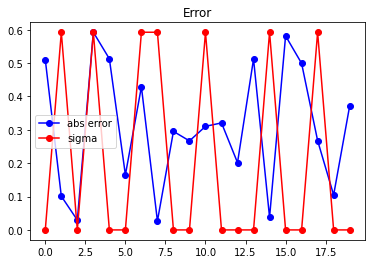

In [10]:
plotErrors(objectives_test,testResults_estimates,testResults_sigmas,idx_sample=0)